<a href="https://colab.research.google.com/github/asattiraju13/datahackathon/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
df = pd.read_csv('gdrive/My Drive/Hackathon: Single-Cell Sequencing/covid-selected-data.csv')
labels = pd.read_csv('gdrive/My Drive/Hackathon: Single-Cell Sequencing/covid-selected-data-labels.csv')

In [ ]:
data = pd.merge(df,labels,on='Unnamed: 0')
data['type'] = data['type'].map({'Normal':0,'Mild':1,'Severe':2})

#X = data.drop('type',axis=1).values  # Apply feature processing, reduction, imbalancing later on / instead of stratified split?
y = data['type'].values

In [ ]:
data = data.iloc[: , 1:]
df = df.iloc[: , 1:]
dfArr = df.to_numpy()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.utils import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.utils import to_categorical

from sklearn.utils import class_weight

sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,train_size=0.8,random_state=0) # n_splits should equal 5
NEpochs = 50
y_pred_all = []; y_all = []; FPR = []; TPR = [];
# Split data into Training + Validation and Test Groups
for train_val_index, test_index in sss.split(dfArr,y):
    X_train_val = dfArr[train_val_index]
    y_train_val = y[train_val_index]
    X_test = dfArr[test_index]
    y_test = y[test_index]
    # Split Train/Val Data into Training and Validation Groups
    sss2 = StratifiedShuffleSplit(n_splits=1,test_size=0.25,train_size=0.75,random_state=0)
    for train_index, val_index in sss2.split(X_train_val,y_train_val):
        X_train = X_train_val[train_index]
        y_train = y_train_val[train_index]
        X_val = X_train_val[val_index]
        y_val = y_train_val[val_index]
        X_train_val = []
        y_train_val = []
        #%% Create Weights for Model Classes
        values, counts = np.unique(y_train, return_counts=True)
        weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.squeeze(y_train))
        class_weights = dict(zip(values, weights))
        # TRAIN AND TEST MODEL HERE
        model = RandomForestClassifier(n_estimators=10, class_weight="balanced")
        model.fit(X_train, y_train) #change trainvalidx when using normalization
        
        fpr, tpr = roc_curve_output(model,y_test,model.predict_proba(X_test))

        FPR = fpr; TPR.append(tpr)
        y_pred_all.append(model.predict(X_test))
        y_all.append(y_test)


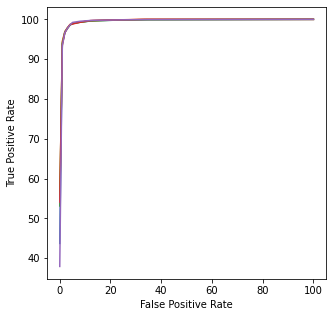

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
for i in range(5):
  plt.plot(100*fpr,100*np.array(TPR)[i,:])

# plt.xlabel(TPR)
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.savefig('gdrive/My Drive/Hackathon: Single-Cell Sequencing/ROC_Curve.png')

In [ ]:
list(FPR)

In [ ]:
from sklearn.metrics import roc_curve

def roc_curve_output(model,labels,probabilities):
    classes = np.unique(labels)
    
    FPR = []; TPR = []; Thresholds = [];
    for i in classes:
        class_val = classes[i];
        # print(class_val)
        nclass_val = np.concatenate((classes[:i], classes[i+1:]),axis=0)

        # print(nclass_val)
        # Rearrange Labels
        labels2 = labels.copy()
        labels2[np.logical_or(labels2==nclass_val[0]*np.ones_like(labels2),labels2==nclass_val[1]*np.ones_like(labels2))] = (np.max(classes)+1)*np.ones((int(np.sum(np.logical_or(labels2==nclass_val[0]*np.ones_like(labels2),labels2==nclass_val[1]*np.ones_like(labels2)))),))
        labels2[labels2==class_val*np.ones_like(labels2)] = np.zeros((np.sum(labels2==class_val*np.ones_like(labels2)),))
        labels2[labels2 == (np.max(classes)+1)*np.ones_like(labels2)] = np.ones((int(np.sum(labels2 == (np.max(classes)+1)*np.ones_like(labels2))),))
        
        # Rearrange Probabilities
        probabilities2 = np.zeros((np.shape(probabilities)[0],))
        probabilities2 = probabilities[:,class_val]
        
        fpr, tpr, thresholds = roc_curve(labels2,probabilities2,pos_label=0)

        mean_fpr = np.linspace(0, 1, 100)
        
        tpr_interp = np.interp(mean_fpr,fpr,tpr)
        
        TPR.append(tpr_interp); #Thresholds.append(thresholds)
    
    TPR = np.mean(TPR,axis=0)
    return(mean_fpr, TPR)#, Thresholds)

In [ ]:
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

clf=RandomForestClassifier(n_estimators=10, class_weight="balanced")
# evaluate the model
cv = StratifiedKFold(n_splits=5, random_state=1)

for i, (train, test) in enumerate(cv.split(df, y)):
    #print(df.iloc[train])
    clf.fit(df.iloc[train], y[train])
    y_pred_proba = clf.predict_proba(df.iloc[test])
    print(roc_auc_score(y[test],y_pred_proba,multi_class = "ovr"))
    
    
    importance = permutation_importance(clf,df.iloc[test],y[test],scoring='recall_weighted',n_repeats=5,n_jobs=-1,random_state=0)
    sorted_idx = importance.importances_mean.argsort()[::-1]
    sorted_idx = sorted_idx[0:101]
    arr1 = df.columns[sorted_idx]
    list1 = arr1.tolist()
    print(list1)
    arr2 = importance.importances_mean[sorted_idx]
    list2 = arr2.tolist()
    print(list2)
    list3 = sorted_idx.tolist()
    print(list3)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9980184113250008
Index(['SNHG25', 'FCER1A', 'C1orf56', 'PHKG1', 'CRH', 'NAPSA', 'AC114760.2',
       'RPS10', 'CXCL10', 'IFITM3', 'AC114291.1', 'F13A1', 'CETN2', 'SOCS1',
       'KLF2', 'SHD', 'TRBV10-2', 'CD69', 'IGLV8-61', 'TCL1A', 'AC058791.1'],
      dtype='object')


[0.01159983 0.01142734 0.01129797 0.00853816 0.00776197 0.00629582
 0.00517464 0.00513152 0.00426908 0.00422596 0.0037085  0.00340664
 0.00340664 0.00306166 0.00263044 0.00228547 0.00219922 0.0021561
 0.00198361 0.00194049 0.00185425]
0.9876326829399255
Index(['SNHG25', 'AL133415.1', 'C1orf56', 'NAPSA', 'SOCS1', 'SHD', 'IFNA8',
       'GATA3', 'RPS10', 'RPS17', 'S100A1', 'CXCL10', 'AC114760.2', 'TRBV10-2',
       'AL138963.3', 'CCR4', 'CETN2', 'NEXN', 'CLU', 'ENPP1', 'FOLR3'],
      dtype='object')


[0.0123329  0.00776197 0.00720138 0.00577835 0.00388098 0.00323415
 0.0029323  0.00241483 0.00228547 0.0021561  0.0021561  0.00206986
 0.00198361 0.00198361 0.00194049 0.00189737 0.00185425 0.00185425
 0.00185425 0.0017

In [ ]:
split1_name = np.array(['C1orf56', 'SNHG25', 'PHKG1', 'CETN2', 'AC114760.2', 'RPS10', 'NAPSA', 'LINC01827', 'SOCS1', 'IL17A', 'ID2', 'OTUD1', 'A2ML1', 'TRBV7-4', 'CD3D', 'TMPRSS11E', 'TNFSF13', 'CD1C', 'IFITM3', 'ZBP1', 'OTOF', 'SCGB1A1', 'IGFL2', 'AC058791.1', 'SCGB3A1', 'AL138963.3', 'MTRNR2L8', 'VEGFA', 'CXCL10', 'CLEC5A', 'H3F3B', 'FCN1', 'MTRNR2L12', 'S100A1', 'CXCL2', 'MARCKSL1', 'CRIP1', 'CXCR4', 'IGLV7-43', 'DNAAF1', 'AC015660.2', 'F2R', 'CCL24', 'EFHC1', 'IL1R2', 'FCER1A', 'HIST1H2AC', 'TRBV11-3', 'MSR1', 'GNG2', 'CD69', 'SLC14A1', 'S100A12', 'IL26', 'RPS17', 'ENDOG', 'SEPT1', 'TBX21', 'FAM102A', 'AP005057.1', 'TRAV2', 'MEOX1', 'MT2A', 'PLD3', 'CCDC30', 'KIF9', 'CCDC153', 'ENAH', 'ATP5IF1', 'MT-ND6', 'PIFO', 'SIGLEC14', 'JUNB', 'HIST1H3C', 'IGHV1-69', 'SDC2', 'TRAV20', 'KLF10', 'GJA1', 'AC017002.3', 'IFITM1', 'IFNA17', 'SLURP2', 'CD207', 'RUNX3', 'INSIG1', 'FOLR3', 'F13A1', 'AC114291.1', 'IFI30', 'SFTA1P', 'RNASE1', 'OLFML3', 'TMSB4X', 'AC010319.3', 'KRT8', 'PLK1', 'FPR1', 'IFNE', 'ENPP1', 'NMUR1'])
split1_value = np.array([0.014661492022423528, 0.010608020698577025, 0.007158257869771511, 0.006123329021129842, 0.005088400172488195, 0.004657179818887513, 0.004053471323846547, 0.0037084950409659533, 0.0034497628288055805, 0.0034497628288055805, 0.0033635187580854263, 0.003191030616645141, 0.0031047865459250534, 0.0029322984044847233, 0.002759810263044482, 0.002673566192324328, 0.002328589909443779, 0.002242345838723647, 0.002242345838723625, 0.0021561017680034934, 0.0021561017680034934, 0.0019836136265632296, 0.001897369555843098, 0.0017248814144027902, 0.0017248814144027902, 0.0015523932729625488, 0.0014661492022424172, 0.0014661492022423727, 0.0013799051315222632, 0.001379905131522241, 0.0012936610608021315, 0.0012936610608021315, 0.0012936610608021315, 0.0012936610608021092, 0.0012074169900819997, 0.0012074169900819997, 0.0012074169900819997, 0.0012074169900819776, 0.0012074169900819776, 0.0010349288486417364, 0.001034928848641692, 0.001034928848641692, 0.0009486847779215824, 0.0009486847779215824, 0.0009486847779215824, 0.0009486847779215824, 0.0009486847779215602, 0.0009486847779215602, 0.0009486847779215602, 0.0009486847779215602, 0.0008624407072014506, 0.0008624407072014506, 0.0008624407072014284, 0.0008624407072014284, 0.0007761966364812966, 0.0007761966364812966, 0.0006899525657611649, 0.0006899525657611649, 0.0006899525657611649, 0.0006899525657611649, 0.0006899525657611649, 0.0006899525657611428, 0.0006899525657611428, 0.0006899525657611428, 0.0006899525657611205, 0.0006037084950410332, 0.000603708495041011, 0.000603708495041011, 0.000603708495041011, 0.0005174644243209015, 0.0005174644243209015, 0.0005174644243209015, 0.0005174644243209015, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.0005174644243208792, 0.000517464424320857, 0.000517464424320857, 0.000517464424320857, 0.000517464424320857, 0.000517464424320857, 0.000517464424320857, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007697, 0.0004312203536007475, 0.0004312203536007475])
split1_idx = np.array([1063, 1012, 1741, 458, 1537, 1042, 782, 1595, 847, 425, 1608, 1383, 878, 1165, 509, 723, 1817, 406, 569, 1830, 1506, 1, 1632, 1623, 2, 1071, 587, 1050, 58, 1070, 1376, 639, 135, 999, 345, 644, 504, 711, 215, 418, 1222, 1757, 323, 572, 539, 134, 829, 227, 1275, 1060, 562, 1778, 84, 1154, 843, 1753, 1076, 1634, 1986, 1453, 414, 1149, 440, 1954, 1804, 717, 1123, 1822, 1633, 1688, 173, 1859, 1458, 656, 969, 1167, 177, 1406, 1845, 1734, 586, 1026, 475, 428, 1600, 695, 535, 1062, 901, 696, 841, 164, 1953, 783, 760, 79, 1811, 1716, 631, 1323, 1408])


split2_name = np.array(['C1orf56', 'AC114760.2', 'PHKG1', 'SNHG25', 'SIGLEC14', 'CETN2', 'AL138963.3', 'NAPSA', 'NEXN', 'ZBTB20-AS2', 'CD3D', 'ZBP1', 'RPS17', 'ID2', 'STAB1', 'AL133415.1', 'FCER1A', 'CD207', 'TRAV23DV6', 'OTUD1', 'CFP', 'AC089983.1', 'SGTB', 'GATA3', 'IFNA7', 'IL17A', 'IFITM3', 'TNFSF10', 'KCNJ15', 'FCGR3B', 'ENDOG', 'CLEC5A', 'GJA1', 'TRBV10-2', 'IGKV2-24', 'CCL7', 'IFNL3', 'SCGB3A1', 'AC004130.1', 'TRAV38-1', 'MX1', 'A2M', 'CRIP1', 'CAMP', 'IGLV7-43', 'EMB', 'TNFSF13', 'MUC12', 'TRAV2', 'VCAN', 'CCDC153', 'PADI1', 'KLF2', 'H3F3B', 'THBD', 'CRYBA4', 'IFNL2', 'ENPP1', 'CD300E', 'CH25H', 'IGKV1-27', 'LILRA5', 'SCGB1A1', 'LINC01827', 'TNF', 'RPS10', 'SAMSN1', 'SOCS1', 'SHD', 'MSR1', 'IGLV10-54', 'IFNA16', 'BCL2', 'PSENEN', 'SQSTM1', 'PLD3', 'NKG7', 'CLCA2', 'PLAC8', 'CD69', 'ATP6V0C', 'HMGB2', 'FCN1', 'AC058791.1', 'EMP1', 'RSAD2', 'A2ML1', 'F13A1', 'GZMA', 'IDO1', 'C1QB', 'C9orf24', 'HIST1H1E', 'AC015660.2', 'HLA-DQA1', 'MATK', 'DUSP5', 'EFHC1', 'RNASE2', 'GBP1', 'IL12B'])
split2_value = np.array([0.011556705476498475, 0.009314359637774893, 0.007589478223372148, 0.00586459680896938, 0.005260888313928414, 0.005088400172488128, 0.005088400172488128, 0.003708495040965909, 0.003708495040965909, 0.0036222509702457995, 0.0032772746873652504, 0.0031910306166451187, 0.003191030616645096, 0.0031047865459249424, 0.0031047865459249424, 0.0030185424752048108, 0.002414833980163866, 0.002414833980163844, 0.002414833980163844, 0.002242345838723581, 0.0021561017680034487, 0.002069857697283317, 0.002069857697283317, 0.0018973695558430314, 0.0018973695558430093, 0.0018111254851228998, 0.0018111254851228774, 0.001724881414402768, 0.001724881414402768, 0.0017248814144027458, 0.0015523932729624823, 0.0014661492022423283, 0.0014661492022423283, 0.0014661492022423283, 0.0014661492022423283, 0.0014661492022423062, 0.0014661492022423062, 0.0013799051315221966, 0.0013799051315221966, 0.0013799051315221966, 0.0013799051315221966, 0.0013799051315221966, 0.0013799051315221745, 0.001293661060802065, 0.0012936610608020426, 0.0012936610608020426, 0.0012936610608020426, 0.001207416990081933, 0.001207416990081911, 0.0012074169900818887, 0.0012074169900818887, 0.0011211729193617791, 0.0011211729193617791, 0.0011211729193617791, 0.001121172919361757, 0.001121172919361757, 0.001121172919361757, 0.001121172919361757, 0.0010349288486416475, 0.0010349288486416254, 0.0010349288486416254, 0.0010349288486416254, 0.0009486847779214935, 0.0009486847779214935, 0.0009486847779214935, 0.000862440707201384, 0.0008624407072013618, 0.0008624407072013618, 0.0008624407072013618, 0.0008624407072013618, 0.0008624407072013618, 0.0008624407072013618, 0.0008624407072013396, 0.0007761966364812301, 0.0007761966364812301, 0.0007761966364812301, 0.0007761966364812301, 0.0007761966364812078, 0.0007761966364812078, 0.0007761966364812078, 0.0007761966364812078, 0.0007761966364811856, 0.0006899525657610983, 0.0006899525657610983, 0.0006899525657610983, 0.0006899525657610983, 0.0006899525657610761, 0.0006899525657610761, 0.0006899525657610761, 0.0006899525657610761, 0.0006899525657610761, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409443, 0.0006037084950409443, 0.0006037084950409443])
split2_idx = np.array([1063, 1537, 1741, 1012, 1859, 458, 1071, 782, 1508, 1683, 509, 1830, 843, 1608, 1307, 1924, 134, 428, 306, 1383, 1951, 1724, 1687, 1667, 1080, 425, 569, 657, 1306, 429, 1753, 1070, 1845, 178, 291, 51, 1966, 2, 1399, 278, 1603, 1213, 504, 720, 215, 1628, 1817, 1107, 414, 524, 1123, 701, 910, 1376, 959, 983, 1719, 1323, 725, 652, 334, 1356, 1, 1595, 384, 1042, 1680, 847, 1035, 1275, 853, 871, 1813, 1065, 1404, 1954, 90, 1402, 703, 562, 1933, 543, 639, 1623, 678, 519, 878, 1062, 107, 304, 387, 66, 751, 1222, 649, 1186, 1013, 572, 1365, 1147, 747])


split3_name = np.array(['PHKG1', 'SNHG25', 'C1orf56', 'AL138963.3', 'AC114760.2', 'NAPSA', 'ID2', 'RPS10', 'CD3D', 'CXCL10', 'SIGLEC14', 'IFNL3', 'NPHP1', 'AC058791.1', 'ZBP1', 'CETN2', 'SEPT1', 'SLC7A5', 'SCGB1A1', 'TRBV7-4', 'CRIP1', 'AL133415.1', 'NEXN', 'MDK', 'SOCS1', 'RPS17', 'TNFSF13', 'IGLV10-54', 'IFNA10', 'LINC01827', 'SHD', 'CD207', 'S100A1', 'IGLV7-43', 'SCGB3A1', 'AC015660.2', 'RSAD2', 'PPBP', 'BCL11A', 'CHIT1', 'ETS2', 'PRDM1', 'NFKBIZ', 'TMPRSS11E', 'H3F3B', 'KLF2', 'PSENEN', 'MT-ATP8', 'CFP', 'MT1F', 'OTUD1', 'HSPB1', 'IL1RN', 'NKG7', 'IFITM3', 'IGHV1-69', 'TRBV7-9', 'RHOB', 'IFNA16', 'IL1R2', 'IGKV3D-11', 'IFI30', 'LGALS2', 'PLD3', 'SLC2A3', 'AC004130.1', 'RIBC1', 'CD79B', 'PTGER2', 'KIF5C', 'FCER1A', 'HAMP', 'TRBV10-2', 'SPP1', 'TSC22D1', 'AP005482.1', 'SPON1', 'COL4A2-AS2', 'TSLP', 'TIMP1', 'IGKC', 'C16orf89', 'CCR1', 'EZR', 'AC015912.3', 'PPP1R32', 'MISP', 'KRT13', 'IDO1', 'HSPA1B', 'IGKV3-7', 'FXYD1', 'HIST2H2BE', 'PLA2G7', 'IGHV3-33', 'LY9', 'AC026726.1', 'CCL24', 'CCL13', 'TRBV6-4', 'SLC18A2'])
split3_value = np.array([0.0107805088400172, 0.010780508840017178, 0.010435532557136695, 0.007072013799051269, 0.0060370849504096215, 0.0050021561017679515, 0.0035360068995256232, 0.003363518758085382, 0.00336351875808536, 0.0032772746873652057, 0.0029322984044846566, 0.0023285899094436903, 0.0023285899094436903, 0.0022423458387235582, 0.0022423458387235582, 0.002242345838723536, 0.0021561017680034045, 0.002069857697283295, 0.002069857697283295, 0.002069857697283295, 0.002069857697283273, 0.002069857697283273, 0.001983613626563141, 0.001897369555842987, 0.001897369555842987, 0.0018111254851228553, 0.0017248814144027237, 0.0017248814144027237, 0.0017248814144027237, 0.0017248814144027237, 0.0017248814144027013, 0.0015523932729624823, 0.0015523932729624601, 0.0015523932729624601, 0.0014661492022423062, 0.0013799051315221966, 0.001293661060802065, 0.001293661060802065, 0.0012936610608020426, 0.0012936610608020426, 0.0012936610608020426, 0.0012074169900818887, 0.0011211729193617791, 0.0010349288486416475, 0.0010349288486416475, 0.0010349288486416254, 0.0010349288486416254, 0.001034928848641603, 0.0009486847779214935, 0.0009486847779214935, 0.0009486847779214935, 0.0009486847779214714, 0.0009486847779214714, 0.0008624407072013618, 0.0008624407072013618, 0.0008624407072013618, 0.0007761966364812301, 0.0007761966364812301, 0.0007761966364812078, 0.0006899525657610761, 0.0006899525657610761, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006037084950409666, 0.0006037084950409443, 0.0006037084950409443, 0.0006037084950409443, 0.0006037084950409443, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0005174644243208127, 0.0005174644243208127, 0.0005174644243208127, 0.0005174644243208127, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0004312203536006809, 0.0004312203536006587, 0.0004312203536006587, 0.0004312203536006587, 0.0004312203536006587, 0.0004312203536006587, 0.0004312203536006587])
split3_idx = np.array([1741, 1012, 1063, 1071, 1537, 782, 1608, 1042, 509, 58, 1859, 1966, 1788, 1623, 1830, 458, 1076, 1825, 1, 1165, 504, 1924, 1508, 741, 847, 843, 1817, 853, 470, 1595, 1035, 428, 999, 215, 2, 1222, 519, 240, 1487, 343, 1710, 1705, 1900, 723, 1376, 910, 1065, 989, 1951, 332, 1383, 394, 269, 90, 569, 969, 86, 973, 871, 539, 1061, 696, 693, 1954, 1292, 1399, 1746, 1882, 1690, 1637, 134, 85, 178, 20, 1711, 1891, 1698, 713, 1697, 353, 21, 1000, 1588, 1330, 845, 1312, 1743, 63, 304, 74, 1816, 1097, 1799, 780, 508, 1265, 1935, 323, 231, 582, 468])


split4_name = np.array(['SNHG25', 'PHKG1', 'C1orf56', 'SOCS1', 'IFITM3', 'CYP19A1', 'RPS17', 'AL133415.1', 'AC114760.2', 'ZBP1', 'RPS10', 'NMUR1', 'CD207', 'KCNJ15', 'ID2', 'CXCL10', 'AC058791.1', 'NAPSA', 'PHLDA2', 'CETN2', 'A2ML1', 'CHIT1', 'RSAD2', 'ATP6V0C', 'CAMP', 'AC105446.1', 'PTGER2', 'KLF2', 'GBP1', 'MTRNR2L12', 'LINC01827', 'STAB1', 'IGKV2D-29', 'CD3D', 'LRRN3', 'MTRNR2L8', 'TRBV11-3', 'MEOX1', 'BANK1', 'NEXN', 'TRAV38-1', 'PTPRE', 'AC010834.2', 'CCDC153', 'CRH', 'IL17A', 'MARCKS', 'TAOK1', 'CXCL8', 'NKG7', 'IGLV9-49', 'PACSIN1', 'SGTB', 'TGM3', 'CD48', 'IER3', 'VCAN', 'SIGLEC14', 'SLC25A37', 'AL138899.1', 'ZFP36L1', 'MT-ND4L', 'HIST1H1E', 'SPTBN1', 'IL6', 'S100A1', 'KLRC2', 'ACAP1', 'CES1', 'RHOB', 'HSPB1', 'IL1R2', 'CXCL2', 'RNASE2', 'AP005057.1', 'PADI1', 'SPHK1', 'MT1F', 'CXCL3', 'LILRA5', 'LAG3', 'TRBV15', 'CTSE', 'SHD', 'AQP4', 'TIMP1', 'NFKBIZ', 'EMB', 'CCL26', 'TNFSF13', 'AC243960.1', 'TSLP', 'CD3G', 'WFDC2', 'IGLV7-43', 'AL139246.5', 'EPPIN', 'IFIT1', 'ACOD1', 'C1QC', 'SLC14A1'])
split4_value = np.array([0.009400603708495048, 0.009228115567054784, 0.008451918930573532, 0.005002156101768041, 0.004484691677447206, 0.004053471323846503, 0.003967227253126371, 0.003880983182406239, 0.0036222509702458217, 0.0032772746873652504, 0.0031047865459249866, 0.0027598102630444375, 0.0027598102630444154, 0.002673566192324306, 0.0026735661923242837, 0.002587322121604152, 0.0021561017680034713, 0.0021561017680034713, 0.002069857697283317, 0.0019836136265631854, 0.0018973695558430538, 0.0018973695558430314, 0.0018111254851229219, 0.0016386373436826584, 0.0016386373436826584, 0.0016386373436826584, 0.0016386373436826141, 0.0016386373436826141, 0.0015523932729625046, 0.0015523932729625046, 0.0015523932729625046, 0.0014661492022423727, 0.001379905131522241, 0.001379905131522241, 0.0013799051315222187, 0.0012936610608021092, 0.0012936610608021092, 0.0012936610608021092, 0.001293661060802065, 0.001207416990081933, 0.001207416990081911, 0.0011211729193618236, 0.0011211729193618015, 0.0011211729193618015, 0.001034928848641692, 0.001034928848641692, 0.001034928848641692, 0.001034928848641692, 0.0010349288486416696, 0.0010349288486416696, 0.0010349288486416696, 0.0010349288486416696, 0.0010349288486416475, 0.0009486847779215602, 0.0009486847779215379, 0.0009486847779215157, 0.0009486847779215157, 0.0009486847779214935, 0.0008624407072014284, 0.0008624407072014062, 0.000862440707201384, 0.000862440707201384, 0.000862440707201384, 0.0007761966364812744, 0.0007761966364812744, 0.0007761966364812744, 0.0007761966364812523, 0.0007761966364812523, 0.0007761966364812523, 0.0007761966364812523, 0.0007761966364812523, 0.0007761966364812301, 0.0007761966364812301, 0.0007761966364812301, 0.0006899525657611428, 0.0006899525657611205, 0.0006899525657611205, 0.0006899525657611205, 0.0006899525657611205, 0.0006899525657611205, 0.0006899525657610983, 0.0006899525657610983, 0.0006899525657610983, 0.0006037084950409888, 0.0006037084950409888, 0.0006037084950409888, 0.0006037084950409888, 0.0006037084950409888, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0006037084950409666, 0.0005174644243208348, 0.0005174644243208348, 0.0005174644243208348, 0.0005174644243208348])
split4_idx = np.array([1012, 1741, 1063, 847, 569, 964, 843, 1924, 1537, 1830, 1042, 1408, 428, 1306, 1608, 58, 1623, 782, 898, 458, 878, 343, 519, 1933, 720, 1480, 1690, 910, 1147, 135, 1595, 1307, 732, 509, 1781, 587, 227, 1149, 1124, 1508, 278, 1552, 839, 1123, 792, 425, 946, 801, 45, 90, 588, 1738, 1687, 1291, 1884, 402, 524, 1859, 933, 886, 1276, 1328, 751, 1676, 795, 999, 665, 1559, 972, 973, 394, 539, 345, 1365, 1453, 701, 1945, 332, 212, 1356, 472, 246, 454, 1035, 1029, 353, 1900, 1628, 636, 1817, 1978, 1697, 648, 5, 215, 844, 825, 777, 590, 244, 1778])


split5_name = np.array(['SNHG25', 'PHKG1', 'AL133415.1', 'C1orf56', 'CYP19A1', 'CD207', 'ZBP1', 'NAPSA', 'CETN2', 'AL138963.3', 'IGKV1D-33', 'AC114760.2', 'RPS17', 'AC015660.2', 'CHIT1', 'ID2', 'AC233755.1', 'BCL2A1', 'ATP6V0C', 'CD3G', 'SOCS1', 'LILRA5', 'IL17A', 'TRBV10-2', 'IL12B', 'TRAV5', 'IGHV1-58', 'CD69', 'MX1', 'AC058791.1', 'SHD', 'HIST1H1E', 'IFITM3', 'EMP1', 'SCGB1A1', 'CXCL10', 'SIGLEC14', 'RNASE2', 'PPBP', 'TMPRSS11E', 'CH25H', 'ZBTB20-AS2', 'IFNA16', 'LINC02154', 'TRBV7-4', 'IFIT3', 'FCGR3B', 'CYP4F22', 'MEOX1', 'LAG3', 'EFHC1', 'H1F0', 'CXCR4', 'CD1A', 'CD1E', 'IFIT2', 'TRAV22', 'SCGB3A1', 'VCAN', 'SFTA2', 'AC020656.1', 'AQP4', 'PTGER2', 'A2M', 'TXNDC5', 'MT-ATP8', 'TNFSF13B', 'MS4A8', 'GATA3', 'H3F3B', 'RPS10', 'CCL7', 'ZFP36L1', 'NMUR1', 'IL3', 'ADAM19', 'METRN', 'C1QB', 'BCL2', 'F13A1', 'NEXN', 'OTUD1', 'MT-ND4L', 'GBP4', 'PDLIM4', 'SDS', 'CD3D', 'DEFB1', 'MTRNR2L12', 'LINC01827', 'ID1', 'CCDC187', 'SPATA17', 'STARD10', 'MSR1', 'RNASE6', 'MARCKS', 'AC135782.1', 'TENT5C', 'AC010834.2', 'S100B'])
split5_value = np.array([0.012850366537300494, 0.009745579991375552, 0.006813281586890851, 0.006295817162570017, 0.005174644243208237, 0.004225959465286722, 0.0037947391116860186, 0.003708495040965887, 0.003708495040965887, 0.003363518758085338, 0.0030185424752047886, 0.0030185424752047886, 0.0025873221216040853, 0.0025010780508839536, 0.002414833980163822, 0.002414833980163822, 0.0024148339801638, 0.0023285899094436678, 0.002242345838723536, 0.002242345838723536, 0.0021561017680034045, 0.002069857697283273, 0.002069857697283273, 0.002069857697283273, 0.0019836136265631186, 0.001897369555842987, 0.001897369555842987, 0.0017248814144027013, 0.0017248814144027013, 0.0017248814144027013, 0.0015523932729624378, 0.0015523932729624378, 0.0015523932729624378, 0.0014661492022423062, 0.0012936610608020205, 0.0012074169900818887, 0.0012074169900818887, 0.0012074169900818887, 0.0012074169900818665, 0.0012074169900818665, 0.001121172919361757, 0.001121172919361757, 0.001121172919361757, 0.0011211729193617349, 0.0011211729193617349, 0.0011211729193617349, 0.0011211729193617349, 0.0011211729193617126, 0.001034928848641603, 0.001034928848641603, 0.001034928848641603, 0.001034928848641581, 0.001034928848641581, 0.0009486847779214714, 0.0009486847779214491, 0.0009486847779214491, 0.0009486847779214491, 0.0008624407072013396, 0.0008624407072013396, 0.0008624407072013396, 0.0008624407072013174, 0.0008624407072013174, 0.0007761966364812078, 0.0007761966364812078, 0.0007761966364812078, 0.0007761966364811856, 0.0007761966364811856, 0.0007761966364811856, 0.0007761966364811856, 0.0007761966364811856, 0.0007761966364811634, 0.0006899525657610761, 0.0006899525657610761, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006899525657610539, 0.0006037084950409443, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409222, 0.0006037084950409, 0.0005174644243208127, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904, 0.0005174644243207904])
split5_idx = np.array([1012, 1741, 1924, 1063, 964, 428, 1830, 782, 458, 1071, 409, 1537, 843, 1222, 343, 1608, 809, 987, 1933, 648, 847, 1356, 425, 178, 747, 219, 1820, 562, 1603, 1623, 1035, 751, 569, 678, 1, 58, 1859, 1365, 240, 723, 652, 1683, 871, 712, 1165, 875, 429, 1748, 1149, 472, 572, 824, 711, 389, 272, 471, 443, 2, 524, 247, 768, 1029, 1690, 1213, 971, 989, 1692, 381, 1667, 1376, 1042, 51, 1276, 1408, 1911, 1410, 1240, 387, 1813, 1062, 1508, 1383, 1328, 1866, 1066, 287, 509, 613, 135, 1595, 577, 1435, 1975, 1974, 1275, 1994, 946, 1631, 1281, 839, 206])

In [ ]:
top_genes = list(set(split1_idx) & set(split2_idx) & set(split3_idx) & set(split4_idx) & set(split5_idx))

In [ ]:
print(len(top_genes))

In [ ]:
print(top_genes)
top_genes_value = []
top_genes_name = []
for i in range(len(top_genes)):
  top_genes_name.append(split1_name[np.where(split1_idx == top_genes[i])])
  split1_int = split1_value[np.where(split1_idx == top_genes[i])]
  split2_int = split2_value[np.where(split2_idx == top_genes[i])]
  split3_int = split3_value[np.where(split3_idx == top_genes[i])]
  split4_int = split4_value[np.where(split4_idx == top_genes[i])]
  split5_int = split5_value[np.where(split5_idx == top_genes[i])]
  splitavg_val = (split1_int + split2_int + split3_int + split4_int + split5_int)/5
  print(splitavg_val)
  top_genes_value.append(splitavg_val)
  
  #top_genes_value.append()


In [ ]:
zipped = sorted(zip(top_genes_value, top_genes_name), reverse=True)

In [ ]:
unzipped_object = zip(*zipped)
unzipped_list = list(unzipped_object)


In [ ]:
zipped_list = list(zipped)

In [ ]:
print(unzipped_list)

In [ ]:
final_gene_values = [0.01028029,0.00990082,0.00890039,0.00541613,0.00382924,0.00372574,0.00301854,0.0029323,0.00267357,0.00255282,0.00246658,0.00229409,0.00227684,0.0021906,0.00217335,0.00170763,0.00169038]
final_gene_name = ['C1orf56','SNHG25','PHKG1','AC114760.2','CETN2','NAPSA','ID2','ZBP1','SOCS1','RPS10','RPS17','CD207','CD3D','IFITM3','SIGLEC14','AC058791.1','LINC01827']

In [ ]:
print(len(final_gene_values))

In [ ]:
from sklearn.metrics import roc_curve
def roc_curve_output(model,labels,probabilities):
    classes = np.unique(labels)
    TPR = []; Thresholds = [];
    for i in classes:
        class_val = classes[i];
        print(class_val)
        nclass_val = np.concatenate((classes[:i], classes[i+1:]),axis=0)
        print(nclass_val)
        # Rearrange Labels
        labels2 = labels.copy()
        labels2[np.logical_or(labels2==nclass_val[0]*np.ones_like(labels2),labels2==nclass_val[1]*np.ones_like(labels2))] = (np.max(classes)+1)*np.ones((int(np.sum(np.logical_or(labels2==nclass_val[0]*np.ones_like(labels2),labels2==nclass_val[1]*np.ones_like(labels2)))),))
        labels2[labels2==class_val*np.ones_like(labels2)] = np.zeros((np.sum(labels2==class_val*np.ones_like(labels2)),))
        labels2[labels2 == (np.max(classes)+1)*np.ones_like(labels2)] = np.ones((int(np.sum(labels2 == (np.max(classes)+1)*np.ones_like(labels2))),))
        # Rearrange Probabilities
        probabilities2 = np.zeros((np.shape(probabilities)[0],))
        probabilities2 = probabilities[:,class_val]
#         probabilities2[:,1] = np.sum((probabilities[:,nclass_val[0]],probabilities[:,nclass_val[1]],),axis=0)
        fpr, tpr, thresholds = roc_curve(labels2,probabilities2)
        mean_fpr = np.linspace(0, 1, 100)
        tpr_interp = np.interp(mean_fpr,fpr,tpr)
        TPR.append(tpr_interp); #Thresholds.append(thresholds)
    TPR = np.mean(TPR,axis=0)
    return(mean_fpr, TPR)#, Thresholds) (edited) 
FPR, TPR = roc_curve_output(clf,np.expand_dims(y_test,axis=1),clf.predict(np.expand_dims(X_test,axis=2)))
plt.figure()
plt.plot(TPR, FPR)



In [ ]:
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

clf=RandomForestClassifier(n_estimators=10, class_weight="balanced")
# evaluate the model
cv = StratifiedShuffleSplit(n_splits=5, random_state=0)



for i, (train, test) in enumerate(cv.split(df, y)):
    #print(df.iloc[train])
    clf.fit(df.iloc[train], y[train])
    #y_pred_proba = clf.predict_proba(df.iloc[test])
    #print('auc:')
    #print(roc_auc_score(y[test],y_pred_proba,multi_class = "ovr"))
    #print('\n')
    #print('f1: ')
    #y_pred = clf.predict(df.iloc[test])
    #print(f1_score(y[test],y_pred,average = 'weighted'))
    #print('\n prevision')
    #print(precision_score(y[test], y_pred,average = 'weighted'))
    #print('\n recall')
    #print(recall_score(y[test], y_pred,average = 'weighted'))    
    #print('\n')
    #print(precision_recall_fscore_support(y[test], y_pred, beta=1.0, average=None))

    #y_probas = # predicted probabilities generated by sklearn classifier


    importance = permutation_importance(clf,df.iloc[test],y[test],scoring='recall_weighted',n_repeats=5,n_jobs=-1,random_state=0)
    sorted_idx = importance.importances_mean.argsort()[::-1]
    sorted_idx = sorted_idx[0:101]
    arr1 = df.columns[sorted_idx]
    list1 = arr1.tolist()
    print(list1)
    arr2 = importance.importances_mean[sorted_idx]
    list2 = arr2.tolist()
    print(list2)
    list3 = sorted_idx.tolist()
    print(list3)
    #imp_data = {df.columns[sorted_idx], importance.importances_mean[sorted_idx] }
    #imp_data = {arr1,arr2}
    #df_imp = pd.DataFrame(imp_data)
    #print(df_imp.head)
    #plt.barh(df.columns[sorted_idx], importance.importances_mean[sorted_idx])
    #plt.xlabel("Permutation Importance")
    #print(arr1)
    print('\n')
    #print(arr2)



['C1orf56', 'SNHG25', 'PHKG1', 'CETN2', 'AC114760.2', 'RPS10', 'NAPSA', 'LINC01827', 'SOCS1', 'IL17A', 'ID2', 'OTUD1', 'A2ML1', 'TRBV7-4', 'CD3D', 'TMPRSS11E', 'TNFSF13', 'CD1C', 'IFITM3', 'ZBP1', 'OTOF', 'SCGB1A1', 'IGFL2', 'AC058791.1', 'SCGB3A1', 'AL138963.3', 'MTRNR2L8', 'VEGFA', 'CXCL10', 'CLEC5A', 'H3F3B', 'FCN1', 'MTRNR2L12', 'S100A1', 'CXCL2', 'MARCKSL1', 'CRIP1', 'CXCR4', 'IGLV7-43', 'DNAAF1', 'AC015660.2', 'F2R', 'CCL24', 'EFHC1', 'IL1R2', 'FCER1A', 'HIST1H2AC', 'TRBV11-3', 'MSR1', 'GNG2', 'CD69', 'SLC14A1', 'S100A12', 'IL26', 'RPS17', 'ENDOG', 'SEPT1', 'TBX21', 'FAM102A', 'AP005057.1', 'TRAV2', 'MEOX1', 'MT2A', 'PLD3', 'CCDC30', 'KIF9', 'CCDC153', 'ENAH', 'ATP5IF1', 'MT-ND6', 'PIFO', 'SIGLEC14', 'JUNB', 'HIST1H3C', 'IGHV1-69', 'SDC2', 'TRAV20', 'KLF10', 'GJA1', 'AC017002.3', 'IFITM1', 'IFNA17', 'SLURP2', 'CD207', 'RUNX3', 'INSIG1', 'FOLR3', 'F13A1', 'AC114291.1', 'IFI30', 'SFTA1P', 'RNASE1', 'OLFML3', 'TMSB4X', 'AC010319.3', 'KRT8', 'PLK1', 'FPR1', 'IFNE', 'ENPP1', 'NMUR1']
